In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
from collections import namedtuple
import random
import copy
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.nn.functional as F

In [43]:
data_train = pd.read_csv('/content/KDDTrain+.txt')
data_test = pd.read_csv('/content/KDDTest+.txt')
#data_test_21 = pd.read_csv('../input/nslkdd/KDDTest-21.txt')

data_train = data_train.iloc[:,:-1]
data_test = data_test.iloc[:,:-1]
#data_test_21 = data_test_21.iloc[:,:-1]

In [44]:
data_train.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,25,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


In [45]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack'])

In [46]:
data_train.columns = columns
data_test.columns = columns
#data_test_21.colums = columns

In [47]:
#data_train.info()

In [48]:
print("Data Train Shape")
print(f"No. of rows - {data_train.shape[0]}")
print(f"No. of columns - {data_train.shape[1]}")
print("Data Test Shape")
print(f"No. of rows - {data_test.shape[0]}")
print(f"No. of columns - {data_test.shape[1]}")


Data Train Shape
No. of rows - 125972
No. of columns - 42
Data Test Shape
No. of rows - 22543
No. of columns - 42


In [49]:
data_train['attack'].unique()


array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [50]:
data_test['attack'].unique()

array(['neptune', 'normal', 'saint', 'mscan', 'guess_passwd', 'smurf',
       'apache2', 'satan', 'buffer_overflow', 'back', 'warezmaster',
       'snmpgetattack', 'processtable', 'pod', 'httptunnel', 'nmap', 'ps',
       'snmpguess', 'ipsweep', 'mailbomb', 'portsweep', 'multihop',
       'named', 'sendmail', 'loadmodule', 'xterm', 'worm', 'teardrop',
       'rootkit', 'xlock', 'perl', 'land', 'xsnoop', 'sqlattack',
       'ftp_write', 'imap', 'udpstorm', 'phf'], dtype=object)

In [51]:
attack_mapping = {
    'normal' : 'normal',
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    'ipsweep' : 'PROBE',
    'nmap' : 'PROBE',
    'portsweep': 'PROBE',
    'satan' : 'PROBE',
    'mscan': 'PROBE',
    'saint': 'PROBE',
    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf' : 'R2L',
    'spy': 'R2L',
    'warezclient' : 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    'buffer_overflow' : 'U2R',
    'loadmodule' : 'U2R',
    'perl' : 'U2R',
    'rootkit' : 'U2R',
    'httptunnel' : 'U2R',
    'ps' : 'U2R',
    'sqlattack' : 'U2R',
    'xterm' : 'U2R'
}
attack_mapping= {
    'normal' : 0,
    'back': 1,
    'land': 1,
    'neptune': 1,
    'pod': 1,
    'smurf': 1,
    'teardrop': 1,
    'mailbomb': 1,
    'apache2': 1,
    'processtable': 1,
    'udpstorm': 1,
    'ipsweep' : 2,
    'nmap' : 2,
    'portsweep': 2,
    'satan' : 2,
    'mscan': 2,
    'saint': 2,
    'ftp_write': 3,
    'guess_passwd': 3,
    'imap': 3,
    'multihop': 3,
    'phf' : 3,
    'spy': 3,
    'warezclient' : 3,
    'warezmaster': 3,
    'sendmail': 3,
    'named': 3,
    'snmpgetattack': 3,
    'snmpguess': 3,
    'xlock': 3,
    'xsnoop': 3,
    'worm': 3,
    'buffer_overflow' : 4,
    'loadmodule' : 4,
    'perl' : 4,
    'rootkit' : 4,
    'httptunnel' : 4,
    'ps' : 4,
    'sqlattack' : 4,
    'xterm' : 4
}
#data_train_classifier = data_train.copy()
#data_train_classifier['attack']= data_train['attack'].map(attack_mapping)
data_train['attack']= data_train['attack'].map(attack_mapping)
#print(data_train_classifier['attack'].unique())
print(data_train['attack'].unique())
data_test['attack']= data_test['attack'].map(attack_mapping)


[0 1 3 2 4]


In [52]:
df = pd.DataFrame(columns =['Normal','Dos','PROBE','R2L','U2R'])

df.loc[df.shape[0]] = (data_train['attack'].value_counts().values)
df.loc[df.shape[0]] = (data_test['attack'].value_counts().values)


df['Total'] = [data_train.shape[0],data_test.shape[0]]
df = df[['Total','Normal','Dos','PROBE','R2L','U2R']]
df.index = ['KDDTrain','KDDTest']
print(df)

           Total  Normal    Dos  PROBE   R2L  U2R
KDDTrain  125972   67342  45927  11656   995   52
KDDTest    22543    9711   7457   2754  2421  200


In [53]:
log_features  = ['duration', 'src_bytes','dst_bytes']
#data_train[log_features] = data_train[log_features].map(lambda x : np.log1p(x))
#data_test[log_features] = data_test[log_features].map(lambda x: np.log1p(x))


In [54]:
column_transformer = ColumnTransformer(
    transformers = [
        ('onehot', OneHotEncoder(), ['protocol_type', 'flag', 'service']),
        ('minmax', MinMaxScaler(), log_features)],
    remainder = 'passthrough'# This will keep the other columns in the DataFrame
)
column_transformer.fit(data_train)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(),
                                 ['protocol_type', 'flag', 'service']),
                                ('minmax', MinMaxScaler(),
                                 ['duration', 'src_bytes', 'dst_bytes'])])

In [55]:
data_train = column_transformer.transform(data_train)

In [56]:
data_test = column_transformer.transform(data_test)

In [57]:
data_train

array([[0.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , ..., 0.  , 0.01, 0.  ],
       ...,
       [0.  , 1.  , 0.  , ..., 0.01, 0.  , 0.  ],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [58]:
data_train = data_train[:10000]

In [59]:
data_train.shape

(10000, 123)

Tạo class ReplayMemory

In [60]:
attacks = [
    'normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
    'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
    'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
    'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
    'loadmodule', 'spy', 'perl'
]

attack_int = [
    'normal',
    'DoS' ,
    'PROBE',
    'R2L',
    'U2R'
]
attack_string = {
    'normal' : 0,
    'DoS' : 1 ,
    'PROBE' : 2,
    'R2L' : 3,
    'U2R' :4
}


## Model v0

In [61]:
transition = namedtuple('transitions', ('state', 'action', 'reward', 'next_state'))

class ReplayMemory:
    def __init__(self, size):
        self.size = size
        self.memory = []

    def push(self, state, action, reward, next_state):
        if len(self.memory) > self.size:
            self.memory.pop()
        self.memory.append(transition(state, action, reward, next_state))

    def sample_batch(self, batch_size):
        if len(self) > batch_size:
            return random.sample(self.memory, batch_size)
        return []

    def __len__(self):
        return len(self.memory)

In [62]:
import torch
import torch.nn as nn
import re
import warnings

from collections import OrderedDict


class MetaModule(nn.Module):
    def __init__(self):
        super(MetaModule, self).__init__()
        self._children_modules_parameters_cache = dict()

    def meta_named_parameters(self, prefix='', recurse=True):
        gen = self._named_members(
            lambda module: module._parameters.items()
            if isinstance(module, MetaModule) else [],
            prefix=prefix, recurse=recurse)
        for elem in gen:
            yield elem

    def meta_parameters(self, recurse=True):
        for name, param in self.meta_named_parameters(recurse=recurse):
            yield param

    def get_subdict(self, params, key=None):
        if params is None:
            return None
        # all name in the given params
        all_names = tuple(params.keys())
        if (key, all_names) not in self._children_modules_parameters_cache:
            # if doesn't specify any key set the value of the name in the given parameters else find the specify key
            if key is None:
                self._children_modules_parameters_cache[(key, all_names)] = all_names

            else:
                key_escape = re.escape(key)
                key_re = re.compile(r'^{0}\.(.+)'.format(key_escape))

                self._children_modules_parameters_cache[(key, all_names)] = [
                    key_re.sub(r'\1', k) for k in all_names if key_re.match(k) is not None]

        names = self._children_modules_parameters_cache[(key, all_names)]
        if not names:
            warnings.warn('Module `{0}` has no parameter corresponding to the '
                          'submodule named `{1}` in the dictionary `params` '
                          'provided as an argument to `forward()`. Using the '
                          'default parameters for this submodule. The list of '
                          'the parameters in `params`: [{2}].'.format(
                          self.__class__.__name__, key, ', '.join(all_names)),
                          stacklevel=2)
            return None
        #print(OrderedDict([(name, params[f'{key}.{name}']) for name in names]))
        return OrderedDict([(name, params[f'{key}.{name}']) for name in names])

In [63]:
class MetaSequential(nn.Sequential, MetaModule):
    __doc__ = nn.Sequential.__doc__

    def forward(self, input, params=None):
        for name, module in self._modules.items():
            if isinstance(module, MetaModule):
                input = module(input, params=self.get_subdict(params, name))
            elif isinstance(module, nn.Module):
                input = module(input)
            else:
                raise TypeError('The module must be either a torch module '
                    '(inheriting from `nn.Module`), or a `MetaModule`. '
                    'Got type: `{0}`'.format(type(module)))
        return input

In [64]:
import torch

from collections import OrderedDict
#from torchmeta.modules import MetaModule


def gradient_update_parameters(model,
                               loss,
                               params=None,
                               step_size=0.5,
                               first_order=False):
    if not isinstance(model, MetaModule):
        raise ValueError('The model must be an instance of `torchmeta.modules.'
                         'MetaModule`, got `{0}`'.format(type(model)))

    if params is None:
        params = OrderedDict(model.meta_named_parameters())


    grads = torch.autograd.grad(loss,
                                params.values(),
                                create_graph=not first_order)

    updated_params = OrderedDict()

    if isinstance(step_size, (dict, OrderedDict)):
        for (name, param), grad in zip(params.items(), grads):
            updated_params[name] = param - step_size[name] * grad

    else:
        for (name, param), grad in zip(params.items(), grads):
            updated_params[name] = param - step_size * grad

    return updated_params

In [65]:
class MetaLinear(nn.Linear, MetaModule):
    __doc__ = nn.Linear.__doc__

    def forward(self, input, params=None):
        if params is None:
            params = OrderedDict(self.named_parameters())
        bias = params.get('bias', None)
        return F.linear(input, params['weight'], bias)


In [66]:
class ActorClassifier(MetaModule):
    def __init__(self):
        super(ActorClassifier, self).__init__()
        self.classifier = MetaLinear(10, 10)

    #def forward(self, x, params=None):
        #if params is None:
           # params = OrderedDict(self.named_parameters())

        # Use get_subdict to get the parameters for the MetaLinear layer
        #sub_params = self.get_subdict(params, 'classifier')
        #return self.classifier(x, sub_params)

# Create an instance of ActorClassifier
model = ActorClassifier()

# Check if self.classifier is an instance of MetaModule
print(isinstance(model.classifier, MetaModule))  # Should print: True

# Print the parameters
for name, param in model.meta_named_parameters():
    print(name, param)


True
classifier.weight Parameter containing:
tensor([[-0.2072, -0.1471, -0.3068, -0.2043, -0.2911,  0.0137,  0.3080, -0.2681,
          0.0378, -0.0717],
        [ 0.0197,  0.0502, -0.1749,  0.1823,  0.0899,  0.0065,  0.1471,  0.1287,
         -0.1176, -0.0777],
        [-0.0466, -0.0313,  0.1490, -0.2707, -0.1025,  0.0621, -0.0914,  0.1130,
          0.1710,  0.2595],
        [ 0.3000,  0.0051, -0.3013,  0.1761,  0.2643,  0.0997, -0.2135, -0.1177,
          0.1074, -0.1544],
        [-0.2050,  0.0378, -0.0792,  0.1590,  0.2180,  0.2143, -0.1061, -0.0700,
         -0.0712, -0.1418],
        [ 0.2229,  0.2944, -0.1744,  0.1957, -0.0699,  0.1540, -0.0857,  0.1148,
         -0.0550,  0.1409],
        [ 0.1046, -0.0202,  0.0802, -0.1032,  0.1550,  0.1466, -0.1501,  0.0728,
         -0.0414, -0.0261],
        [-0.1434,  0.1058,  0.0672,  0.0445, -0.0808, -0.1795, -0.1348,  0.0498,
         -0.3104,  0.0418],
        [ 0.0801, -0.0429,  0.1826, -0.2365,  0.2213,  0.0805, -0.1547,  0.0748,
  

In [67]:
class MyMetaModule(MetaModule):
    def __init__(self):
        super().__init__()
        self.classifier = MetaLinear(10, 10)
        self.submodule2 = MetaLinear(10,10)
model = MyMetaModule()
params = OrderedDict(model.named_parameters())
sub_params = model.get_subdict(params, 'submodule2')
print(sub_params)


OrderedDict([('weight', Parameter containing:
tensor([[ 0.0591, -0.2063,  0.2588, -0.0566, -0.1811, -0.2845,  0.3037,  0.2210,
         -0.1240,  0.2923],
        [ 0.1341,  0.0556,  0.0474,  0.1122,  0.1920,  0.2078,  0.1686,  0.1896,
          0.2906,  0.1234],
        [ 0.1385,  0.2100, -0.1580,  0.1961,  0.2192, -0.0618,  0.2070, -0.2705,
          0.1282, -0.1926],
        [-0.1120,  0.2016,  0.1696, -0.2362,  0.1581, -0.3118, -0.0105,  0.0214,
          0.3128, -0.1789],
        [ 0.2238, -0.0589, -0.0781, -0.0139,  0.2121,  0.2363, -0.0821,  0.1465,
          0.1190, -0.2125],
        [-0.2653, -0.0640, -0.2510, -0.1804,  0.0522, -0.0650,  0.1590,  0.0956,
         -0.1627, -0.1223],
        [ 0.1824,  0.2057,  0.2312,  0.2768, -0.2989,  0.2962, -0.3089, -0.0168,
          0.0999, -0.1624],
        [-0.1933,  0.1596, -0.2012, -0.1939,  0.1593,  0.2490, -0.2252,  0.1385,
          0.2271, -0.1790],
        [ 0.2987, -0.1341,  0.2013,  0.2314,  0.1616,  0.2660,  0.1884, -0.0317,
 

In [68]:
import torch
import torch.nn as nn

def hidden_layer(input_dim, output_dim):
        return MetaSequential(
            MetaLinear(input_dim,output_dim),
            nn.ReLU()
        )
class ActorClassifier(MetaModule):

    def __init__(self):
        super(ActorClassifier, self).__init__()
        self.features = MetaSequential(
            hidden_layer(122,100),
            hidden_layer(100,100),
            hidden_layer(100,100),
            hidden_layer(100,5)
        )
        self.output = nn.Softmax(dim = 1)

    def forward(self, inputs, params=None):
        x = self.features(inputs, params=self.get_subdict(params, 'features'))
        output = self.output(x)
        return output

class QCriticClassifier(MetaModule):
    def __init__(self):
        super(QCriticClassifier, self).__init__()
        self.features = MetaSequential(
            hidden_layer(122,100),
            hidden_layer(100,100),
            hidden_layer(100,100),
            hidden_layer(100,5)
        )

    def forward(self, inputs, params=None):
        output = self.features(inputs, params=self.get_subdict(params, 'features'))
        #output = self.output(output)
        return output

class VCriticClassifier(MetaModule):
    def __init__(self):
        super(VCriticClassifier, self).__init__()
        self.features = MetaSequential(
            hidden_layer(122,100),
            hidden_layer(100,100),
            hidden_layer(100,100),
            hidden_layer(100,1)
        )


    def forward(self, inputs, params=None):
        output = self.features (inputs, params=self.get_subdict(params, 'features'))
        return output



In [69]:
class ActorEnvironment(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(122,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,23),
            nn.Softmax(dim=1)
        )
        self.output = nn.Softmax(dim = 1)

    def forward(self, x):
        output = self.seq(x)
        output = self.output(output)
        return output

class QCriticEnvironment(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(122,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,23),
            #nn.ReLU()
        )

    def forward(self, x):
        output = self.seq(x)
        return output

class VCriticEnvironment(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(122,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,1),
            #nn.ReLU()
        )

    def forward(self, x):
        output = self.seq(x)
        return output

In [70]:
#Seperate the dataset for different tasks
data_train_reshape = data_train[:,:-1]
normal_dataset = data_train_reshape[data_train[:,-1] == 0]
dos_dataset = data_train_reshape[data_train[:,-1] == 1]
probe_dataset = data_train_reshape[data_train[:,-1] == 2]
r2l_dataset = data_train_reshape[data_train[:,-1] == 3]
u2r_dataset = data_train_reshape[data_train[:,-1] == 4]


In [71]:
#Simple 0/1 reward
def Reward_Calculation(actual_action,action_classifier):
    #print(f"actual action is {actual_action} and classifier is {action_classifier}")
    if actual_action == action_classifier :
        reward_env = 0
        reward_classifier = 1
    else :
        reward_env = 1
        reward_classifier = 0
    return reward_env, reward_classifier

def get_action_env(model, state):
    action_prob = model(state)
    action = torch.multinomial(action_prob,num_samples = 1)
    entropy_reg = -torch.sum(action_prob*torch.log2(action_prob),dim=1)
    return action, entropy_reg

def get_action_classifier(model, state, params = None):
    action_prob = model(state)
    entropy_reg = -torch.sum(action_prob*torch.log2(action_prob),dim=1)
    action = torch.multinomial(action_prob,num_samples = 1)

    return action,entropy_reg

def update_weights_polyak_avg(target_model ,model, tau = 0.05 ):
    target_weights = target_model.state_dict()
    model_weights = model.state_dict()
    updated_params = OrderedDict()

    for (name, param), (name2,param2) in zip(model_weights.items(), target_weights.items()):
        updated_params[name] = tau*param + (1-tau)*param2
    target_model.load_state_dict(updated_params)


In [72]:
def get_accuracy(logits, targets):
    _, predictions = torch.max(logits, dim=-1)
    return torch.mean(predictions.eq(targets).float())

In [73]:
#Hyperparameter
epochs = 50
batch_size = 180
sample_size = 30
lr = 0.0005
discount = 0.0005
beta = 0.001
alpha = 0.05
K = 15
H = 20
replay_length = 100

In [74]:
def reset_grad():
    actor_classifier.zero_grad()
    q1_classifier.zero_grad()
    q2_classifier.zero_grad()
    v_classifier.zero_grad()
    v_classifier_target.zero_grad()
    actor_environment.zero_grad()
    q1_environment.zero_grad()
    q2_environment.zero_grad()
    v_environment.zero_grad()
    v_environment_target.zero_grad()

def create_step_trajectory(dataset, length):
    state_set = dataset[np.random.choice(dataset.shape[0],length,replace = True)]
    state_set = state_set.astype(np.float32)
    state_set = torch.from_numpy(state_set)
    return state_set

In [75]:
#Create Environment Agent and Classifier Agent
actor_environment = ActorEnvironment()
q1_environment = QCriticEnvironment()
q2_environment = QCriticEnvironment()
v_environment = VCriticEnvironment()
v_environment_target = VCriticEnvironment()

actor_classifier = ActorClassifier()
q1_classifier = QCriticClassifier()
q2_classifier = QCriticClassifier()
v_classifier = VCriticClassifier()
v_classifier_target = copy.deepcopy(v_classifier)

em_e = ReplayMemory(replay_length)
em_c = ReplayMemory(replay_length)

mse = nn.MSELoss()

actor_optim = torch.optim.Adam(actor_classifier.parameters(),lr=lr)
v_optim = torch.optim.Adam(v_classifier.parameters(),lr=lr)
q1_optim = torch.optim.Adam(q1_classifier.parameters(),lr=lr)
q2_optim = torch.optim.Adam(q2_classifier.parameters(),lr=lr)

actor_optim_env = torch.optim.Adam(actor_environment.parameters(),lr=lr)
v_optim_env = torch.optim.Adam(v_environment.parameters(),lr=lr)
q1_optim_env = torch.optim.Adam(q1_environment.parameters(),lr=lr)
q2_optim_env = torch.optim.Adam(q2_environment.parameters(),lr=lr)


for epoch in range(epochs):
    reward_sum = 0
    reward_sum_env = 0
    # initialize
    index = np.random.choice(data_train.shape[0],1,replace = False)

    state_0 = data_train_reshape[index]
    state_0 = state_0.astype(np.float32)
    state_0 = torch.from_numpy(state_0)

    action_env, entropy_reg_env = get_action_env(actor_environment,state_0)
    #Map from 23 specific Label to 5 General Label
    action_taken = attack_mapping[attacks[action_env]]
    #print("Attack is " ,action_taken )

    # Sample st
    sample_set = data_train_reshape[data_train[:,-1] == action_taken]

    index = np.random.choice(sample_set.shape[0],1,replace = False)
    state = data_train_reshape[index]
    state = state.astype(np.float32)
    state = torch.from_numpy(state)

    for t in range(sample_size):
        #print(f"{t}")
        action_classifier,entropy_reg_classifier= get_action_classifier(actor_classifier,state)

        reward_env, reward_classifier = Reward_Calculation(action_taken, action_classifier)

        reward_sum += reward_classifier
        reward_sum_env +=reward_env
        action_env_next,entropy_reg_env_next = get_action_env(actor_environment, state)
        #action_prob_env = actor_environment(state)
        action_taken_next = attack_mapping[attacks[action_env_next]]

        # Sample st+1
        sample_set = data_train_reshape[data_train[:,-1] == action_taken_next]

        index = np.random.choice(sample_set.shape[0],1,replace = False)

        state_next = data_train_reshape[index]
        state_next = state_next.astype(np.float32)
        state_next = torch.from_numpy(state_next)

        em_e.push(state, action_env, reward_env, state_next)
        em_c.push(state, action_classifier, reward_classifier, state_next)

        state = state_next.clone()
        action_env = action_env_next.clone()

        if len(em_e) > batch_size and len(em_c) > batch_size:
            # Train Env
            loss_actor_env = 0
            loss_v_env = 0
            loss_q1_env = 0
            loss_q2_env = 0

            sample_env = em_e.sample_batch(batch_size)

            state_env = [s.state for s in sample_env]
            state_env = torch.stack(state_env)
            state_env = torch.squeeze(state_env, dim=1)
            state_env_truncate = state_env[0:batch_size-1].clone()

            reward_env_s = [r.reward for r in sample_env]
            reward_env_s = torch.Tensor(reward_env_s)
            reward_env_s = reward_env_s[0:batch_size-1].clone()

            next_state_env = [s.next_state for s in sample_env]
            next_state_env = torch.stack(next_state_env)
            next_state_env = torch.squeeze(next_state_env, dim=1)
            next_state_env = next_state_env[0:batch_size-1]

            action_env_s = [a.action for a in sample_env]

            action_probs_env = actor_environment(state_env_truncate)
            entropy_reg_env = -torch.sum(action_probs_env*torch.log2(action_probs_env),dim=1)

            value_vals_env =  v_environment(state_env)
            value_vals_env_target = v_environment_target(state_env)

            q1_val_env = q1_environment(state_env_truncate)
            q1_vals_env = torch.Tensor(len(state_env_truncate))
            q2_val_env = q2_environment(state_env_truncate)
            q2_vals_env = torch.Tensor(len(state_env_truncate))

            for i in range(batch_size-1):
                # q value at the action chosen
                q1_vals_env[i] = q1_val_env[i][action_env_s[i]]
                q2_vals_env[i] = q2_val_env[i][action_env_s[i]]

            loss_actor_env = torch.mean(-torch.min(q1_vals_env,q2_vals_env) + beta*entropy_reg_env)
            loss_v_env = torch.mean(torch.min(q1_vals_env,q2_vals_env) - beta*entropy_reg_env - value_vals_env[0:batch_size-1])
            loss_q1_env = torch.mean(q1_vals_env - (reward_env_s + discount*value_vals_env_target[1:batch_size]))
            loss_q2_env = torch.mean(q2_vals_env - (reward_env_s + discount*value_vals_env_target[1:batch_size]))

            #Update environment
            loss_actor_env.backward(retain_graph = True)
            actor_optim_env.step()
            loss_q1_env.backward(retain_graph = True)
            q1_optim_env.step()
            loss_q2_env.backward()
            q2_optim_env.step()
            update_weights_polyak_avg(v_environment_target, v_environment)

            #break

            # # Train Classifier
            sample = em_c.sample_batch(batch_size)
            tasks = [t.action for t in sample]

            outer_actor_loss = 0
            outer_q1_loss = 0
            outer_q2_loss = 0
            outer_v_loss = 0

            accuracy  = torch.tensor(0)
            for task in tasks:

                if task == 0:
                    dataset = normal_dataset
                elif task == 1:
                    dataset = dos_dataset
                elif task == 2:
                    dataset = probe_dataset
                elif task == 3:
                    dataset = r2l_dataset
                else:
                    dataset = u2r_dataset

                #Sample K traject from given dataset
                for k in range(K):
                    #Each traject take H step

                    state_set = create_step_trajectory(dataset, H+1)
                    state_set_test = create_step_trajectory(dataset, H)

                    action_probs = actor_classifier(state_set[0:H])

                    # Tạo phân phối Categorical với các xác suất đã cho
                    distribution = torch.distributions.Categorical(probs=action_probs)

                    # Lấy mẫu hành động từ phân phối này
                    actions = distribution.sample()

                    value_vals =  v_classifier(state_set)
                    value_vals_target = v_classifier_target(state_set)

                    q1_vals = q1_classifier(state_set[0:H])
                    q1_val = torch.Tensor(H)
                    q2_vals = q2_classifier(state_set[0:H])
                    q2_val = torch.Tensor(H)

                    for i in range(H):
                        q1_val[i] = q1_vals[i][actions[i]]
                        q2_val[i] = q2_vals[i][actions[i]]

                    reward = torch.zeros(H)

                    for count in range(H):
                        if (task == actions[count]):
                            reward[count] = 1
                        else:
                            reward[count] = 0

                    entropy_reg = -torch.sum(action_probs*torch.log2(action_probs),dim=1)

                    loss_actor = torch.mean(-torch.min(q1_val,q2_val)+ beta*entropy_reg)
                    loss_v = torch.mean(torch.min(q1_val,q2_val) - beta*entropy_reg - value_vals[0:H])
                    loss_q1 = torch.mean(q1_val - (reward + discount*value_vals_target[1:H+1]))
                    loss_q2 = torch.mean(q2_val - (reward + discount*value_vals_target[1:H+1]))
                    #ensures that gradients from previous iterations don't interfere with the current computation
                    reset_grad()

                    #Calculate Actor outer loss
                    params_actor = gradient_update_parameters(actor_classifier, loss_actor, step_size = alpha)
                    actions = actor_classifier(state_set_test)
                    actions_new = actor_classifier(state_set_test, params = params_actor)
                    outer_actor_loss += mse(actions_new, actions)

                    #Calculate V Critic outer loss
                    params_v = gradient_update_parameters(v_classifier, loss_v, step_size = alpha)
                    v_values_new = v_classifier(state_set_test, params= params_v)
                    v_values = v_classifier(state_set_test)

                    outer_v_loss += mse(v_values_new, v_values)

                    #Calculate Q Critic outer loss
                    params_q1 = gradient_update_parameters(q1_classifier, loss_q1, step_size = alpha)
                    q1_values_new = q1_classifier(state_set_test, params= params_q1)
                    q1_values = q1_classifier(state_set_test)
                    outer_q1_loss +=mse(q1_values_new, q1_values)

                    params_q2 = gradient_update_parameters(q2_classifier, loss_q2, step_size = alpha)
                    q2_values_new= q2_classifier(state_set_test, params= params_q2)
                    q2_values = q2_classifier(state_set_test)
                    outer_q2_loss += mse(q2_values_new, q2_values)

                    #print(f"Reward is : {torch.sum(reward)}\n")
                    #For debug
                    #break


            reset_grad()

            #Update Classifier
            #print("Update weight")
            outer_actor_loss.backward()
            actor_optim.step()

            outer_v_loss.backward()
            v_optim.step()

            outer_q1_loss.backward()
            q1_optim.step()

            outer_q2_loss.backward()
            q2_optim.step()

            update_weights_polyak_avg(v_classifier_target ,v_classifier)
    #save_model()
    print(f"epoch {epoch} Reward of env is: {reward_sum_env} \n Reward of classifier is : {reward_sum} \n" )


epoch 0 Reward of env is: 20 
 Reward of classifier is : 10 

epoch 1 Reward of env is: 19 
 Reward of classifier is : 11 

epoch 2 Reward of env is: 19 
 Reward of classifier is : 11 

epoch 3 Reward of env is: 23 
 Reward of classifier is : 7 

epoch 4 Reward of env is: 17 
 Reward of classifier is : 13 

epoch 5 Reward of env is: 26 
 Reward of classifier is : 4 

epoch 6 Reward of env is: 15 
 Reward of classifier is : 15 

epoch 7 Reward of env is: 15 
 Reward of classifier is : 15 

epoch 8 Reward of env is: 27 
 Reward of classifier is : 3 

epoch 9 Reward of env is: 24 
 Reward of classifier is : 6 

epoch 10 Reward of env is: 17 
 Reward of classifier is : 13 

epoch 11 Reward of env is: 20 
 Reward of classifier is : 10 

epoch 12 Reward of env is: 27 
 Reward of classifier is : 3 

epoch 13 Reward of env is: 28 
 Reward of classifier is : 2 

epoch 14 Reward of env is: 26 
 Reward of classifier is : 4 

epoch 15 Reward of env is: 27 
 Reward of classifier is : 3 

epoch 16 R

## Model Evaluation

In [76]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(actor_classifier, actor_environment, test_data, test_labels):
    # Convert test data to tensor if needed
    test_data = torch.tensor(test_data, dtype=torch.float32)

    # Get predictions from both models
    with torch.no_grad():
        classifier_probs = actor_classifier(test_data)
        environment_probs = actor_environment(test_data)

        classifier_preds = torch.argmax(classifier_probs, dim=1).numpy()
        environment_preds = torch.argmax(environment_probs, dim=1).numpy()

        # For environment predictions, map from 23 specific labels to 5 general labels
        environment_preds = np.array([attack_mapping[attacks[pred]] for pred in environment_preds])

    # Calculate accuracies
    classifier_accuracy = accuracy_score(test_labels, classifier_preds)
    environment_accuracy = accuracy_score(test_labels, environment_preds)

    # Generate confusion matrices
    classifier_cm = confusion_matrix(test_labels, classifier_preds)
    environment_cm = confusion_matrix(test_labels, environment_preds)

    # Plot confusion matrices
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(classifier_cm, annot=True, fmt='d',
                xticklabels=['Normal', 'DoS', 'PROBE', 'R2L', 'U2R'],
                yticklabels=['Normal', 'DoS', 'PROBE', 'R2L', 'U2R'])
    plt.title(f'Classifier Confusion Matrix\nAccuracy: {classifier_accuracy:.4f}')

    plt.subplot(1, 2, 2)
    sns.heatmap(environment_cm, annot=True, fmt='d',
                xticklabels=['Normal', 'DoS', 'PROBE', 'R2L', 'U2R'],
                yticklabels=['Normal', 'DoS', 'PROBE', 'R2L', 'U2R'])
    plt.title(f'Environment Model Confusion Matrix\nAccuracy: {environment_accuracy:.4f}')

    plt.tight_layout()
    plt.show()

    return classifier_accuracy, environment_accuracy, classifier_cm, environment_cm

def print_detailed_metrics(classifier_accuracy, environment_accuracy, classifier_cm, environment_cm):
    print("===== Model Evaluation Results =====")
    print("\nClassifier Model:")
    print(f"Overall Accuracy: {classifier_accuracy:.4f}")
    print("\nConfusion Matrix:")
    print("Labels: [Normal, DoS, PROBE, R2L, U2R]")
    print(classifier_cm)

    print("\nEnvironment Model:")
    print(f"Overall Accuracy: {environment_accuracy:.4f}")
    print("\nConfusion Matrix:")
    print("Labels: [Normal, DoS, PROBE, R2L, U2R]")
    print(environment_cm)

    # Calculate per-class metrics for both models
    classes = ['Normal', 'DoS', 'PROBE', 'R2L', 'U2R']

    print("\nPer-class metrics:")
    print("\nClassifier Model:")
    for i, class_name in enumerate(classes):
        precision = classifier_cm[i, i] / classifier_cm[:, i].sum() if classifier_cm[:, i].sum() != 0 else 0
        recall = classifier_cm[i, i] / classifier_cm[i, :].sum() if classifier_cm[i, :].sum() != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        print(f"{class_name}:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")

    print("\nEnvironment Model:")
    for i, class_name in enumerate(classes):
        precision = environment_cm[i, i] / environment_cm[:, i].sum() if environment_cm[:, i].sum() != 0 else 0
        recall = environment_cm[i, i] / environment_cm[i, :].sum() if environment_cm[i, :].sum() != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        print(f"{class_name}:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")


Evaluating models on test data...


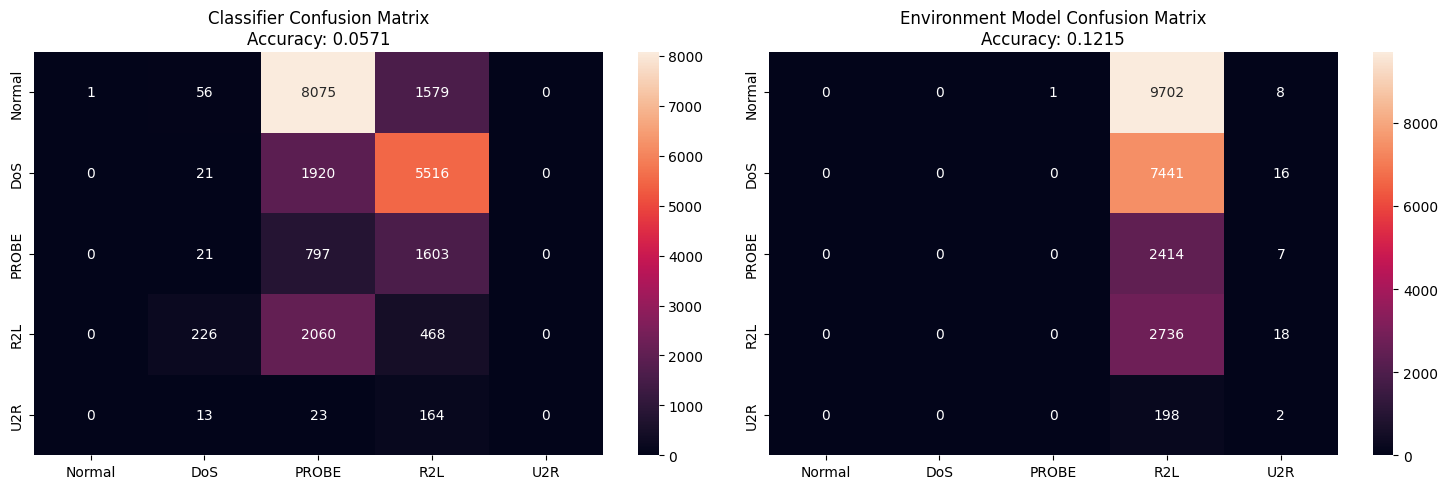

In [77]:
# After training ends
print("\nEvaluating models on test data...")

# Prepare test data
test_data = data_test[:,:-1]  # Remove the last column (labels)
test_labels = data_test[:,-1]  # Get just the labels

# Evaluate both models
classifier_accuracy, environment_accuracy, classifier_cm, environment_cm = evaluate_model(
    actor_classifier,
    actor_environment,
    test_data,
    test_labels
)

# Print detailed metrics
#print_detailed_metrics(classifier_accuracy, environment_accuracy, classifier_cm, environment_cm)

# Other ML and DL models

## RBF - SVM

Accuracy: 0.6547487024797054
F1-score: 0.599894778174883
Classifier Accuracy: 0.6547487024797054


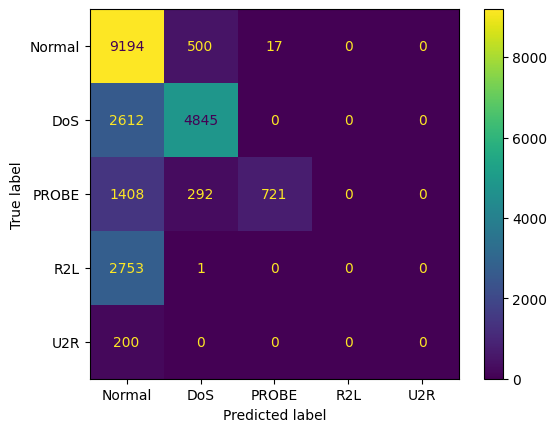

In [81]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Assuming 'data_train' and 'data_test' are already preprocessed as in your previous code

# Split data into features (X) and labels (y)
X_train = data_train[:, :-1]
y_train = data_train[:, -1].astype(int)
X_test = data_test[:, :-1]
y_test = data_test[:, -1].astype(int)

# Initialize and train the RBF SVM model
rbf_svm = SVC(kernel='rbf', gamma='scale', C=1.0)  # You can adjust parameters like C and gamma
rbf_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rbf_svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted') # Use weighted average for multi-class

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

cm = confusion_matrix(y_test, y_pred)
classifier_accuracy = accuracy_score(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Normal', 'DoS', 'PROBE', 'R2L', 'U2R'])
disp.plot()
print(f"Classifier Accuracy: {classifier_accuracy}")

## J 48

Initial J48 Accuracy: 0.728873708024664
Initial J48 F1-score: 0.6943210773340373
Classifier Accuracy: 0.728873708024664


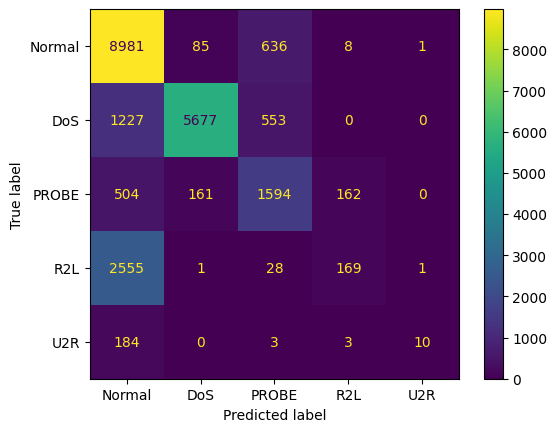

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# Assuming X_train, y_train, X_test, y_test are defined as in the previous code

# Initialize and train the J48 (Decision Tree) model
j48_model = DecisionTreeClassifier() # You can add parameters for J48 as needed
j48_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = j48_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Initial J48 Accuracy: {accuracy}")
print(f"Initial J48 F1-score: {f1}")

cm = confusion_matrix(y_test, y_pred)
classifier_accuracy = accuracy_score(test_labels, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Normal', 'DoS', 'PROBE', 'R2L', 'U2R'])
disp.plot()
plt.show()

## MultiLayer Perceptron

Classifier Accuracy: 0.7708823138002928


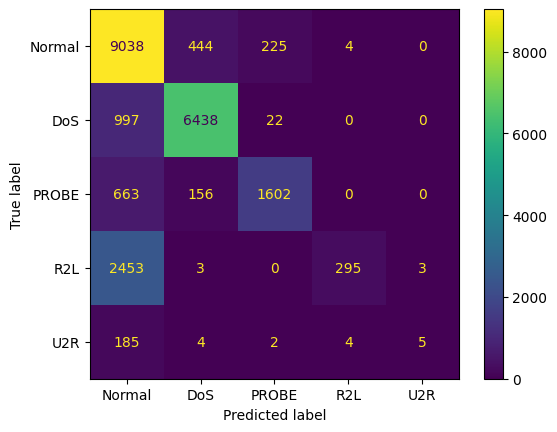

In [80]:
# prompt: write code to train a basic MLP on this train data and plot the confusion matrix

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming X_train, y_train, X_test, y_test are defined as in the previous code

# Initialize and train the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001,
                     solver='adam', random_state=21,tol=0.000000001) # Adjust parameters as needed

mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
classifier_accuracy = accuracy_score(test_labels, y_pred)
print(f"Classifier Accuracy: {classifier_accuracy}")
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Normal', 'DoS', 'PROBE', 'R2L', 'U2R'])
disp.plot()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


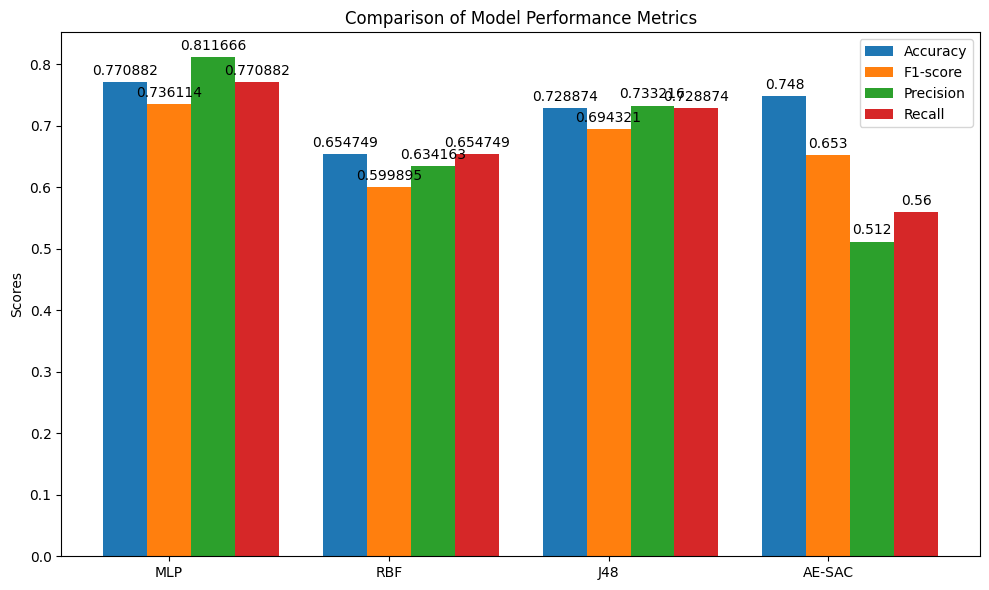

In [89]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return accuracy, f1, precision, recall

# Assuming y_test and predictions from each model (y_pred_mlp, y_pred_rbf, y_pred_j48) are already available
# Example:
y_pred_mlp = mlp.predict(X_test)
y_pred_rbf = rbf_svm.predict(X_test)
y_pred_j48 = j48_model.predict(X_test)

metrics_mlp = calculate_metrics(y_test, y_pred_mlp) # Replace with your MLP prediction variable
metrics_rbf = calculate_metrics(y_test, y_pred_rbf) # Replace with your RBF SVM prediction variable
metrics_j48 = calculate_metrics(y_test, y_pred_j48) # Replace with your J48 prediction variable


models = ['MLP', 'RBF', 'J48' , 'AE-SAC']
metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall']

metric_values = {
    'MLP': list(metrics_mlp),
    'RBF': list(metrics_rbf),
    'J48': list(metrics_j48),
    'AE-SAC' : [ 0.748 , 0.653, 0.512, 0.56 ]
}

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects = []

for i, metric in enumerate(metrics):
    values = [metric_values[model][i] for model in models]
    rect = ax.bar(x + i * width, values, width, label=metric)
    rects.append(rect)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x + width, models)
ax.legend()

ax.bar_label(rects[0], padding=3)
ax.bar_label(rects[1], padding=3)
ax.bar_label(rects[2], padding=3)
ax.bar_label(rects[3], padding=3)


fig.tight_layout()
plt.show()